# High Value Customer Identification (Insiders)

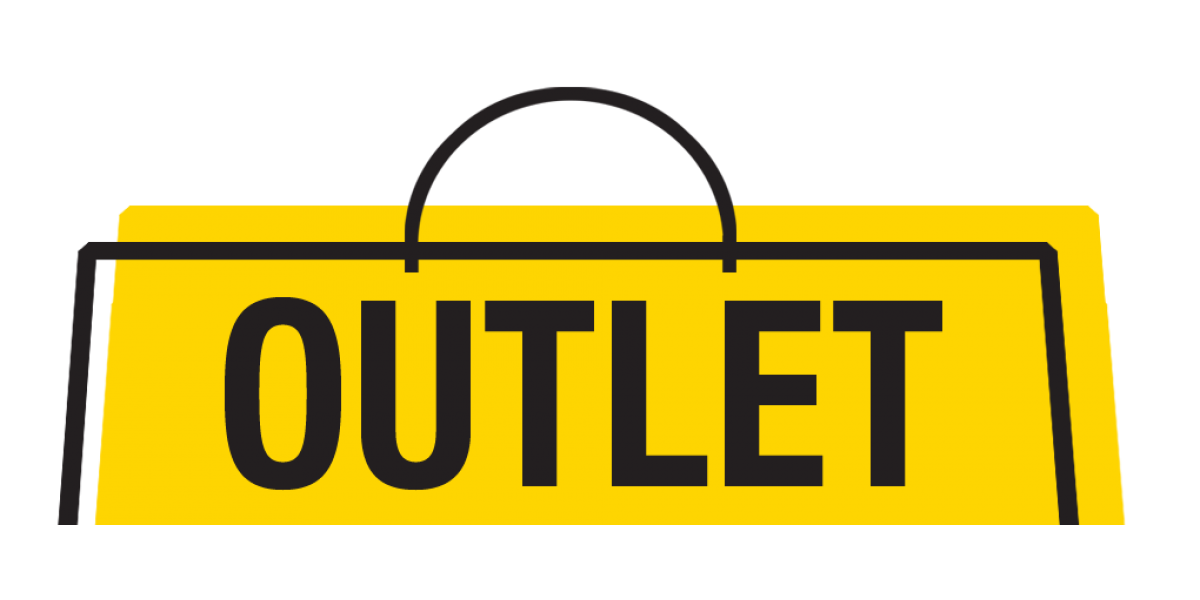

The company All in One Place is a Multibrand Outlet company, i.e., it sells second line products of various brands at a lower price, through an e-commerce platform. In 1 year of operation, the marketing team realized that some customers in its base buy more expensive products with high frequency and end up contributing with a significant portion of the company's revenue. Based on this perception, the marketing team will launch a loyalty program for the best customers in the base, called Insiders. But the team does not have an advanced knowledge of data analysis to choose the program participants. For this reason, the marketing team asked the data team to select eligible customers for the program, using advanced data manipulation techniques.

**Table of contents**

* 0.0. [Imports](#imports)

# Solution Planning (IOT) <a id='solution_planning'></a>

## Input <a id='input'></a>

1. Business Problem
    * Select most valuable customers to join a loyalty program.
2. Dataset
    * E-commerce online sales, for 1 year.

## Output  <a id='output'></a>

1. List of customers who will join the Insiders program.
    * List:
    | client_id | is_insider |
    | ---  | --- |
    | 10323 | yes/1 |
    | 10323 | no/0 |
    
2. Aswer business questions

    1. Who are the people eligible to join the Insiders program?
    2. How many customers will be part of the group?
    3. What are the main characteristics of these customers?
    4. What is the percentage of revenue contribution coming from the Insiders?
    5. What is the expected revenue of this group for the next months?
    6. What are the conditions for a person to be eligible to join Insiders?
    7. How can a person be removed from the Insiders program?
    8. What is the guarantee that the Insiders program is better than the rest of the base ?
    9. What actions can the marketing team take to increase revenue?

## Tasks <a id='tasks'></a>

**1. Who are the people eligible to join the Insiders program?**

* What is being eligible? What are most valuable customers?
* Revenue:
    * High average ticket
    * High LTV (Life Time Value)
    * Low Recency (Las time of purcharse)
    * Big basket size
    * Low churn probability
    * High LTV Prediction
    * High propensity to buy
* Cost:
    * Low return rate
* Shopping experience:
    * High average evaluation

**2. How many customers will be part of the group?**

* Total number of customers
* % of Insiders Group

**3. What are the main characteristics of these customers?**

* Get some customer's characteristics
    * Age
    * Localization

* Get consumption characteristics
    * Clustering attributes

**4. What is the percentage of revenue contribution coming from the Insiders?**

* Anual total revenue
* Insiders' revenue

**5. What is the expected revenue of this group for the next months?**

* Insiders' LTV
* Cohort Analysis
* Timeseries (ARIMA, ARMA, Prophet)

**6. What are the conditions for a person to be eligible to join Insiders?**

* Define model periodicity (1, 3 months)
* The person should be similar to the selected customers.

**7. How can a person be removed from the Insiders program?**

* Define model periodicity (1, 3 months)
* The person should be different to the selected customers.

**8. What is the guarantee that the Insiders program is better than the rest of the base ?**

* Hypothesis Testing
* A/B Testing
* A/B Bayesian Testing

**9. What actions can the marketing team take to increase revenue?**

* Discount
* Purcharse preference
* Shipping
* Company visit

## Solution Benchmark <a id='solution_benchmark'></a>

* RFM Score

<img src="./img/rfm.png" alt="RFM" style="width: 600px;"/>

# 0.0. Imports <a id='imports'></a>

In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster import hierarchy as hc

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from pandas_profiling import ProfileReport

from umap.umap_ import UMAP

from IPython.display import HTML

init_notebook_mode(connected=True)

D:\Anaconda\envs\py385\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\py385\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\Anaconda\envs\py385\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 0.1. Helper Functions <a id='helper_functions'></a>

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', None)
    
    sns.set()

In [3]:
jupyter_settings()

## 0.1. Load dataset <a id='load_dataset'></a>

In [4]:
# load data
df_raw = pd.read_csv('data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw.drop(df_raw.columns[len(df_raw.columns)-1], axis=1, inplace=True)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0. Data Description <a id='data_description'></a>

In [ ]:
df1 = df_raw.copy()

## 1.1. Rename Columns <a id='rename_columns'></a>

In [ ]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions <a id='data_dimensions'></a>

In [ ]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

## 1.3. Data Types <a id='data_types'></a>

In [ ]:
df1.dtypes

## 1.4. Check Missing Values <a id='check_na'></a>

In [ ]:
df1.isna().sum()

## 1.5. Fill Missing Values <a id='fill_na'></a>

In [ ]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]
df_missing.head()

In [ ]:
# create reference for customer_id
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original data with reference dataframe
df1 = df1.merge(df_backup, on = 'invoice_no', how = 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns = ['customer_id_x', 'customer_id_y'], axis = 1)

df1.head()

In [ ]:
df1.isna().sum()

## 1.6. Change DTypes <a id='change_dtypes'></a>

In [ ]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

df1.head()

In [ ]:
df1.dtypes

## 1.7. Descriptive Statistical <a id='descriptive_statistical'></a>

In [ ]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes <a id='numerical_attributes'></a>

In [ ]:
num = num_attributes.describe().T
num['skew'] = num_attributes.apply(lambda x: x.skew())
num['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())
num

**Investigate**
1. Negative quantity
2. Min unit_price equal 0

### 1.7.2. Categorical Attributes <a id='categorical_attributes'></a>

#### Invoice No

In [ ]:
cat_attributes.head()

In [ ]:
# number of invoice_no that has letters inside it
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(f'Number of distinct invoice_no that has letter in it: {len(df_letter_invoices.invoice_no.unique())}')
print(f'Number of total invoice_no that has letter in it: {len(df_letter_invoices)}')
n = len(df_letter_invoices.loc[df_letter_invoices['quantity'] < 0])
print(f'Number of invoice_no that has letter in it and quantity is less than 0: {n}')
df_letter_invoices.head()

**To do:**

* Use negative values in feature engineering

#### Stock Code

In [ ]:
# number of stock_code that has letters inside it
aux = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

In [ ]:
# number of stock_code that has ONLY letters inside it
aux = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].drop_duplicates()
print(len(aux.stock_code.unique()))
aux.head()

In [ ]:
# distinct stock_code with only letters
aux['stock_code'].unique()

**To do:**

* Remove stock_code in: 'POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'

#### Description

**To do:**

* Remove Description

#### Country

In [ ]:
# countries in dataset
len(df1['country'].unique())

In [ ]:
# check purchase's volumetry
df1['country'].value_counts(normalize = True)

In [ ]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

# 2.0. Data Filtering <a id='data_filtering'></a>

In [ ]:
df2 = df1.copy()

In [ ]:
df2.loc[df2['unit_price'] > 0.001, ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10)

In [ ]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code != 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# country
df2 = df2[~df2['country'].isin(['Unspecified', 'European Community'])]

# description
df2.drop(columns = 'description', inplace = True)

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - Negative numbers means devolution
df2_returns = df2.loc[df2['quantity'] < 0, :].copy()
df2_purchases = df2.loc[df2['quantity'] > 0, :].copy()

# 3.0. Feature Engineering <a id='feature_engineering'></a>

In [ ]:
df3 = df2.copy()

## 3.1. Feature Creation <a id='feature_creation'></a>

In [ ]:
# data reference
df_ref = df3.drop(columns = ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country']) \
            .drop_duplicates(ignore_index = True)
df_ref.head()

### 3.1.1. Gross Revenue <a id='gross_revenue'></a>

In [ ]:
# Gross Revenue = quantity * price
df2_purchases['gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = df_ref.merge(df_monetary, how = 'left', on = 'customer_id')
df_ref.isna().sum()

### 3.1.2. Recency - Last Purchase <a id='recency'></a>

In [ ]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = df_ref.merge(df_recency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

### 3.1.3. Total Purchases <a id='total_purchases'></a>

In [ ]:
# Total Purchases
df_freq = df2_purchases[['customer_id', 'invoice_no']].drop_duplicates() \
                                                      .groupby('customer_id') \
                                                      .count() \
                                                      .reset_index() \
                                                      .rename(columns = {'invoice_no' : 'total_invoices'})
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

### 3.1.4. Total Items Purchased <a id='total_items_purchased'></a>

In [ ]:
# Total Products Purchases
df_freq = df2_purchases[['customer_id', 'quantity']].groupby('customer_id') \
                                                    .sum() \
                                                    .reset_index() \
                                                    .rename(columns = {'quantity' : 'total_items'})
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

### 3.1.5. Total Products Purchased <a id='total_products_purchased'></a>

In [ ]:
# Total Products Purchases
df_freq = df2_purchases[['customer_id', 'stock_code']].groupby('customer_id') \
                                                      .count() \
                                                      .reset_index() \
                                                      .rename(columns = {'stock_code' : 'total_products'})
df_ref = df_ref.merge(df_freq, on = 'customer_id', how = 'left')
df_ref.isna().sum()

### 3.1.6. Average Ticket Value <a id='average_ticket_value'></a>

In [ ]:
# Avg Ticket
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns = {'gross_revenue' : 'avg_ticket'})
df_ref = df_ref.merge(df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

### 3.1.7. Average Recency <a id='average_recency'></a>

In [ ]:
# Average Recency
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending = False)
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['next_date'] = df_aux['invoice_date'].shift()

df_aux['average_recency_days'] = df_aux.apply(lambda x: (x['next_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop(columns = ['invoice_date', 'next_customer_id', 'next_date'], axis = 1).dropna()

df_avg_recency = df_aux.groupby('customer_id').mean().reset_index()

df_ref = df_ref.merge(df_avg_recency, on = 'customer_id', how = 'left')

df_ref.isna().sum()

### 3.1.8. Frequency Purchase  <a id='frequency_purchase'></a>

In [ ]:
df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

In [ ]:
df_aux = df2_purchases[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates() \
                                                                     .groupby('customer_id') \
                                                                     .agg(max_ = ('invoice_date', 'max'),
                                                                          min_ = ('invoice_date', 'min'),
                                                                          days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                          buy_ = ('invoice_no', 'count')).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1)

# Merge
df_ref = df_ref.merge(df_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')

df_ref.isna().sum()

### 3.1.9. Returns  <a id='returns'></a>

In [ ]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns = {'quantity' : 'returns'})
df_returns['returns'] = df_returns['returns'] * -1
df_ref = df_ref.merge(df_returns, on = 'customer_id', how = 'left')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

### 3.1.10. Basket Size  <a id='basket_size'></a>

Total products purchased.

* Invoice No = Purchase
* Stock Code = Product
* Quantity = Item

In [ ]:
df_aux = df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id') \
                                                                        .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                             n_products = ('quantity', 'sum')) \
                                                                        .reset_index()

# calculate
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how = 'left', on = 'customer_id')

df_ref.isna().sum()

### 3.1.11. Unique Basket Size  <a id='basket_size'></a>

Distinct product quantity for each purchase.

In [ ]:
df_aux = df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id') \
                                                                        .agg(n_purchase = ('invoice_no', 'nunique'),
                                                                             n_products = ('stock_code', 'count')) \
                                                                        .reset_index()

# calculate
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how = 'left', on = 'customer_id')

df_ref.isna().sum()

# 4.0. EDA (Exploratory Data Analysis) <a id='eda'></a>

In [ ]:
df4 = df_ref.dropna().copy()

## 4.1. Univariate Analysis <a id='univariate_analysis'></a>

In [ ]:
# profile = ProfileReport(df4)
# profile.to_file('eda/eda_analysis.html')

### 4.1.1. Gross Revenue <a id='gross_revenue'></a>

In [ ]:
df4.sort_values('gross_revenue', ascending = False).head()

### 4.1.2. Total Items <a id='total_items'></a>

In [ ]:
df4[df4['total_products'] == 7838]

### 4.1.3. Average Ticket <a id='average_ticket'></a>

In [ ]:
# bad user removed
# df3[df3['customer_id'] == 16446]

### 4.1.4. Frequency <a id='frequency'></a>

In [ ]:
df4[df4['frequency'] == 17]

### 4.1.5. Average Basket Size <a id='average_basket_size'></a>

In [ ]:
# bad user removed
# df4[df4['avg_basket_size'] == 40498.5]

## 4.2. Bivariate Analysis <a id='bivariate_analysis'></a>

**Main Insights**:

* Frequency has low variance
* Avg Ticket has low variance

In [ ]:
# sns.pairplot(df4.drop(columns = 'customer_id'));

## 4.3. Spatial Study <a id='spatial_study'></a>

In [ ]:
# original dataset
# df43 = df4.copy()

# filtered dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'total_products', 'frequency', 'returns']
df43 = df4[cols_selected]

In [ ]:
# scaling
mm = MinMaxScaler()

df43['customer_id'] = mm.fit_transform(df43[['customer_id']])
df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
# df43['total_invoices'] = mm.fit_transform(df43[['total_invoices']])
# df43['total_items'] = mm.fit_transform(df43[['total_items']])
df43['total_products'] = mm.fit_transform(df43[['total_products']])
# df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
# df43['average_recency_days'] = mm.fit_transform(df43[['average_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['returns'] = mm.fit_transform(df43[['returns']])
# df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
# df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

## 4.3.1. PCA <a id='pca'></a>

In [ ]:
X = df43.copy()

In [ ]:
X.head()

In [ ]:
pca = PCA(n_components = X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color = 'black');

# pca components to dataframe
df_pca = pd.DataFrame(principal_components)

In [ ]:
fig = px.scatter(df_pca, x = 0, y = 1)
fig.show()

## 4.3.2. UMAP <a id='pca'></a>

In [ ]:
reducer = UMAP(random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x_umap'] = embedding[:, 0]
df_pca['embedding_y_umap'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x_umap', 
                y = 'embedding_y_umap',
                data = df_pca);

## 4.3.3. t-SNE <a id='tsne'></a>

In [ ]:
reducer = TSNE(n_components = 2, n_jobs = 1, random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x_tsne'] = embedding[:, 0]
df_pca['embedding_y_tsne'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x_tsne', 
                y = 'embedding_y_tsne',
                data = df_pca);

## 4.3.4. Tree-Based Embedding <a id='tsne'></a>

In [59]:
# training dataset
X = df43.drop(columns = ['customer_id', 'gross_revenue'], axis = 1)
y = df43['gross_revenue']

# model definition
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

# model training
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [60]:
# leafs
df_leaf = pd.DataFrame(rf.apply(X))
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,3466,3439,3727,3677,3656,3752,3613,3688,3684,3493,3668,3543,3545,3578,3553,3491,3318,3422,3409,3246,3527,3655,3637,3582,3500,3426,3283,3394,3389,3769,3305,3610,3338,3458,3563,3393,3487,3654,3459,3619,3502,3623,3646,3675,3414,3437,3501,3743,3595,3380,3567,3544,3518,3394,3744,3697,3394,3659,3437,3696,3486,3483,3534,3765,3639,3490,3498,3563,3515,3522,3710,3736,3639,3706,3713,3506,3647,3564,3649,3412,3577,3546,3505,3672,3466,3629,3665,3688,3626,3410,3450,3392,3423,3678,3588,3706,3670,3406,3624,3653
1,3339,3397,3600,3056,3024,2978,3153,3518,3314,3246,3048,3445,3306,3396,3497,3412,3291,3281,3323,3176,3359,3526,2894,2897,3372,3222,3273,3303,3253,3157,3244,3364,3318,3311,3318,3373,3372,3137,3059,3059,3361,3170,3065,3129,3382,3412,3298,3264,3339,3254,3151,3428,3508,2992,3511,3102,3333,3648,3202,3231,3362,3301,2965,3152,3451,3209,3067,2860,3414,3257,3182,3108,3163,2701,3293,3124,3227,3431,3367,3391,3282,3272,3369,3533,3340,3069,3276,3155,3045,3383,2810,3270,3058,2943,3404,2996,2976,3307,3025,3508
2,3513,2982,3627,3579,3555,3651,3284,3551,3330,3332,3614,3473,3422,3517,3470,3471,3023,3362,3449,3238,3476,3519,3261,3246,3401,3384,3030,3350,3206,3660,3248,3395,3299,3495,3514,3468,3534,3580,3484,3538,3554,3224,3553,3563,3316,3424,3355,3242,3542,3383,3558,3500,3452,3469,3567,3645,3485,3534,3210,3310,3493,3440,3522,3643,3491,3443,3250,3560,3458,3001,3644,3648,3655,3622,3053,3510,3273,3508,3397,3078,3261,3220,3399,3560,3406,3560,3290,3715,3333,3430,3407,3341,3479,3530,3526,3595,3044,3382,3539,3585
3,1085,543,1213,309,854,345,537,933,1296,1233,814,362,569,466,1074,821,927,719,381,1105,564,393,1254,412,465,587,1231,646,1163,326,621,544,1211,985,1159,1041,1426,402,399,1281,591,1259,1031,540,1136,892,587,469,722,971,407,386,1115,601,1504,1154,313,531,785,674,648,970,996,1265,1148,315,494,869,323,1111,673,1254,360,1470,1257,665,607,1209,1238,387,1163,1135,1042,1158,374,969,978,958,750,1112,538,1546,576,600,1057,1308,568,523,924,891
4,437,632,377,889,911,778,1023,37,562,485,143,511,50,714,528,461,544,1102,722,573,688,91,138,712,889,740,83,923,544,1689,59,652,596,335,472,493,361,1241,717,735,676,752,620,69,528,396,780,647,989,731,825,713,322,1020,536,496,1024,95,122,1212,1059,716,592,499,543,623,603,359,631,603,963,774,948,86,106,911,974,512,502,652,53,104,105,717,659,509,493,725,1053,506,895,611,877,700,764,468,689,882,1319,461


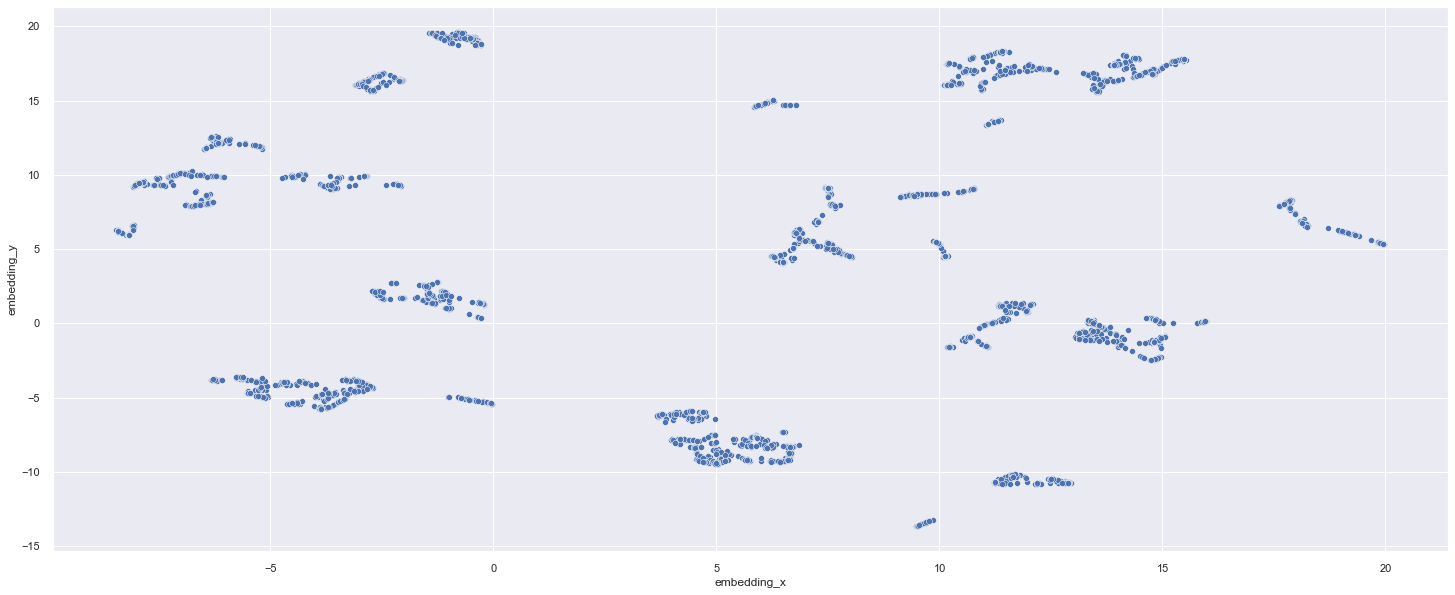

In [61]:
# umap on leaves
reducer = UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', 
                y = 'embedding_y',
                data = df_tree);

# 5. Data Preparation <a id='data_preparation'></a>

In [62]:
# df5 = df4.copy()
df5 = df_tree.copy()

In [63]:
df5.columns

Index(['embedding_x', 'embedding_y'], dtype='object')

# 6.0. Feature Selection <a id='feature_selection'></a>

In [64]:
# df6 = df5[columns].copy()
df6 = df_tree.copy()

# 7.0. Hyperparameter Fine-Tunning <a id='hyperparameter'></a>

In [65]:
# X = df6.drop(columns = 'customer_id')
X = df_tree.copy()

In [66]:
clusters = np.arange(2, 26, 1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25])

## 7.1. K-Means <a id='kmeans'></a>

In [67]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = KMeans(n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = silhouette_score(X, labels, metric = 'euclidean')
    kmeans_list.append(sil)

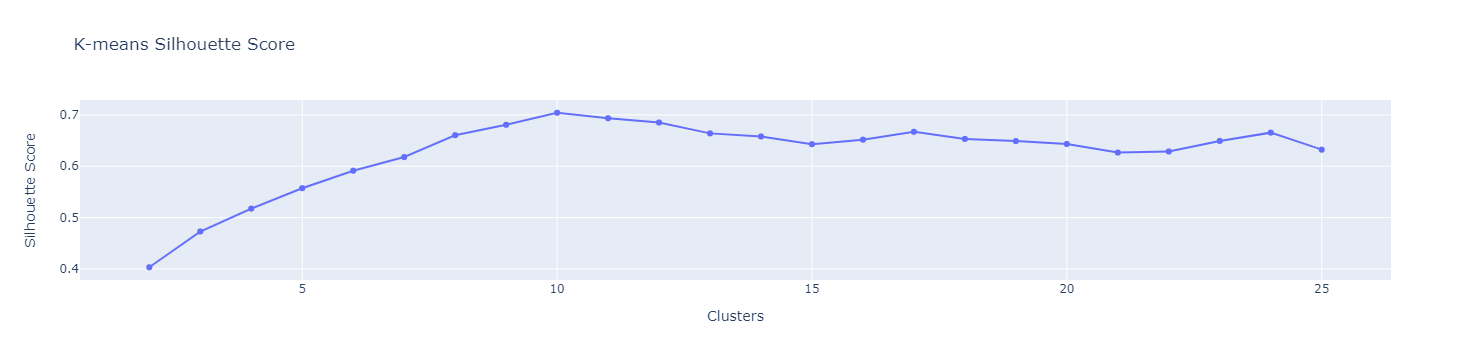

In [68]:
fig = px.line(x = clusters, y = kmeans_list, markers=True, title = 'K-means Silhouette Score')
fig.update_layout(yaxis_title = 'Silhouette Score', xaxis_title = 'Clusters')
fig.show()

## 7.2. GMM <a id='gmm'></a>

In [69]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = GaussianMixture(n_components = k, random_state = 42, n_init = 30)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    sil = silhouette_score(X, labels, metric = 'euclidean')
    gmm_list.append(sil)

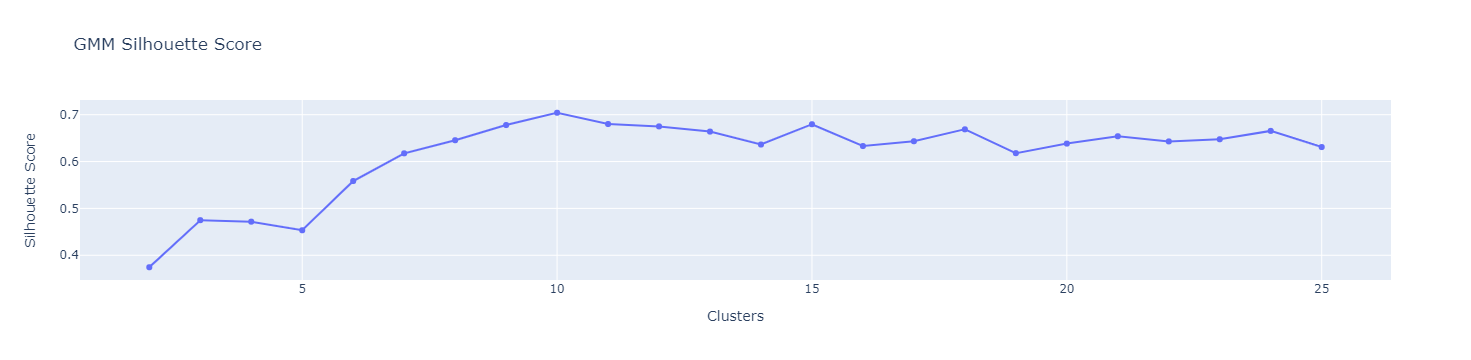

In [70]:
fig = px.line(x = clusters, y = gmm_list, markers=True, title = 'GMM Silhouette Score')
fig.update_layout(yaxis_title = 'Silhouette Score', xaxis_title = 'Clusters')
fig.show()

## 7.3. Hierarchical Clustering <a id='hierarchical_clustering'></a>

In [71]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

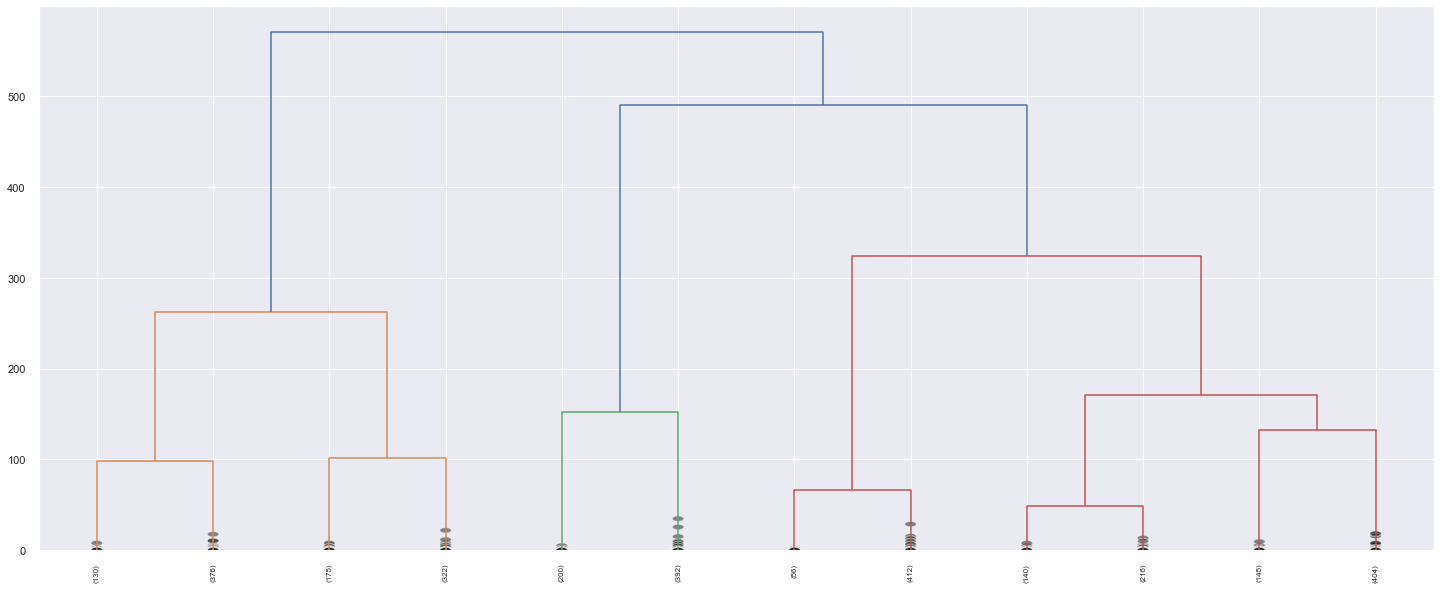

In [72]:
hc.dendrogram(hc_model, truncate_mode = 'lastp', p = 12, leaf_rotation = 90, leaf_font_size = 8, show_contracted = True)

plt.show()

### 7.3.1. Hierarchical Clustering Silhouette Score <a id='hclustering_silhouette'></a>

In [73]:
hc_list = []

for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')

    # metrics
    sil = silhouette_score(X, labels, metric = 'euclidean')
    hc_list.append(sil)

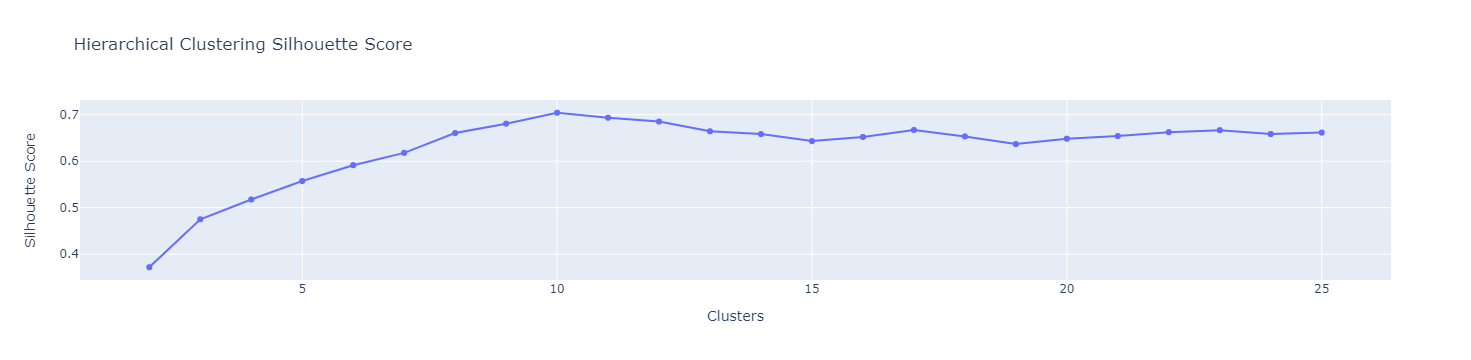

In [74]:
fig = px.line(x = clusters, y = hc_list, markers=True, title = 'Hierarchical Clustering Silhouette Score')
fig.update_layout(yaxis_title = 'Silhouette Score', xaxis_title = 'Clusters')
fig.show()

## 7.4. DBSCAN <a id='dbscan'></a>

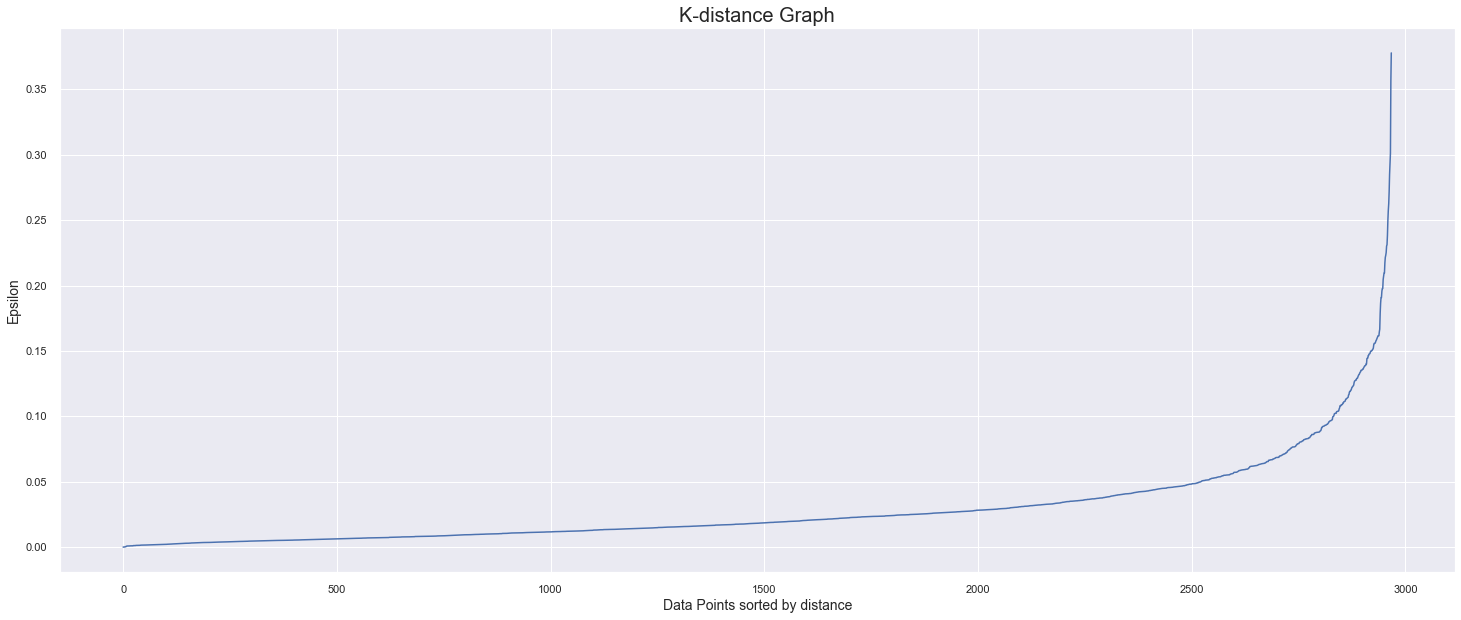

In [75]:
min_samples = 2

# select eps
neighbors = NearestNeighbors(n_neighbors = min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

# plot
distances = np.sort(distances, axis = 0)
plt.plot(distances[:, 1])
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [76]:
eps = 2
min_samples = 20

# model definition
dbscan_model = DBSCAN(eps = eps, min_samples = min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

# metrics 
sil = silhouette_score(X, labels, metric = 'euclidean')
print(f'Silhouette Score: {sil}')
print(f'Number of clusters: {len(np.delete(np.unique(labels), -1))}')

Silhouette Score: 0.6259320378303528
Number of clusters: 14


## 7.5. Results <a id='results'></a>

In [77]:
df_results = pd.DataFrame(
    {
        'K-Means' : kmeans_list,
        'GMM' : gmm_list,
        'HC' : hc_list
    }
).T

df_results.columns = clusters

df_results.style.highlight_max(color = 'lightgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
K-Means,0.403305,0.472922,0.517474,0.557248,0.591324,0.617831,0.660476,0.680678,0.704146,0.693466,0.685148,0.663994,0.658050,0.642932,0.651717,0.667083,0.653159,0.649022,0.643333,0.626630,0.628722,0.649288,0.665408,0.632281
GMM,0.374409,0.474898,0.471713,0.453331,0.558438,0.617527,0.645488,0.677910,0.704146,0.680090,0.675032,0.663931,0.636344,0.679615,0.633093,0.643345,0.668770,0.617907,0.638309,0.653991,0.642977,0.647562,0.665408,0.630937
HC,0.371668,0.474898,0.517474,0.557248,0.591324,0.617831,0.660476,0.680678,0.704146,0.693466,0.685217,0.664250,0.658237,0.643120,0.651914,0.667083,0.653191,0.636708,0.648304,0.653994,0.662376,0.666668,0.658322,0.661474


## 7.6. Silhouette Analysis <a id='silhouette_analysis'></a>

K = 2, Silhouette Score: 0.3716677725315094
K = 3, Silhouette Score: 0.4748983085155487
K = 4, Silhouette Score: 0.5174739956855774
K = 5, Silhouette Score: 0.5572484731674194
K = 6, Silhouette Score: 0.5913244485855103
K = 7, Silhouette Score: 0.6178311109542847
K = 8, Silhouette Score: 0.6604759097099304
K = 9, Silhouette Score: 0.6806782484054565
K = 10, Silhouette Score: 0.7041463255882263
K = 11, Silhouette Score: 0.6934661269187927
K = 12, Silhouette Score: 0.6852166652679443
K = 13, Silhouette Score: 0.6642495393753052
K = 14, Silhouette Score: 0.6582366228103638
K = 15, Silhouette Score: 0.6431195735931396
K = 16, Silhouette Score: 0.6519140601158142
K = 17, Silhouette Score: 0.6670833826065063
K = 18, Silhouette Score: 0.6531907320022583
K = 19, Silhouette Score: 0.6367076635360718
K = 20, Silhouette Score: 0.6483035683631897
K = 21, Silhouette Score: 0.6539942622184753
K = 22, Silhouette Score: 0.6623757481575012
K = 23, Silhouette Score: 0.6666680574417114
K = 24, Silhouette

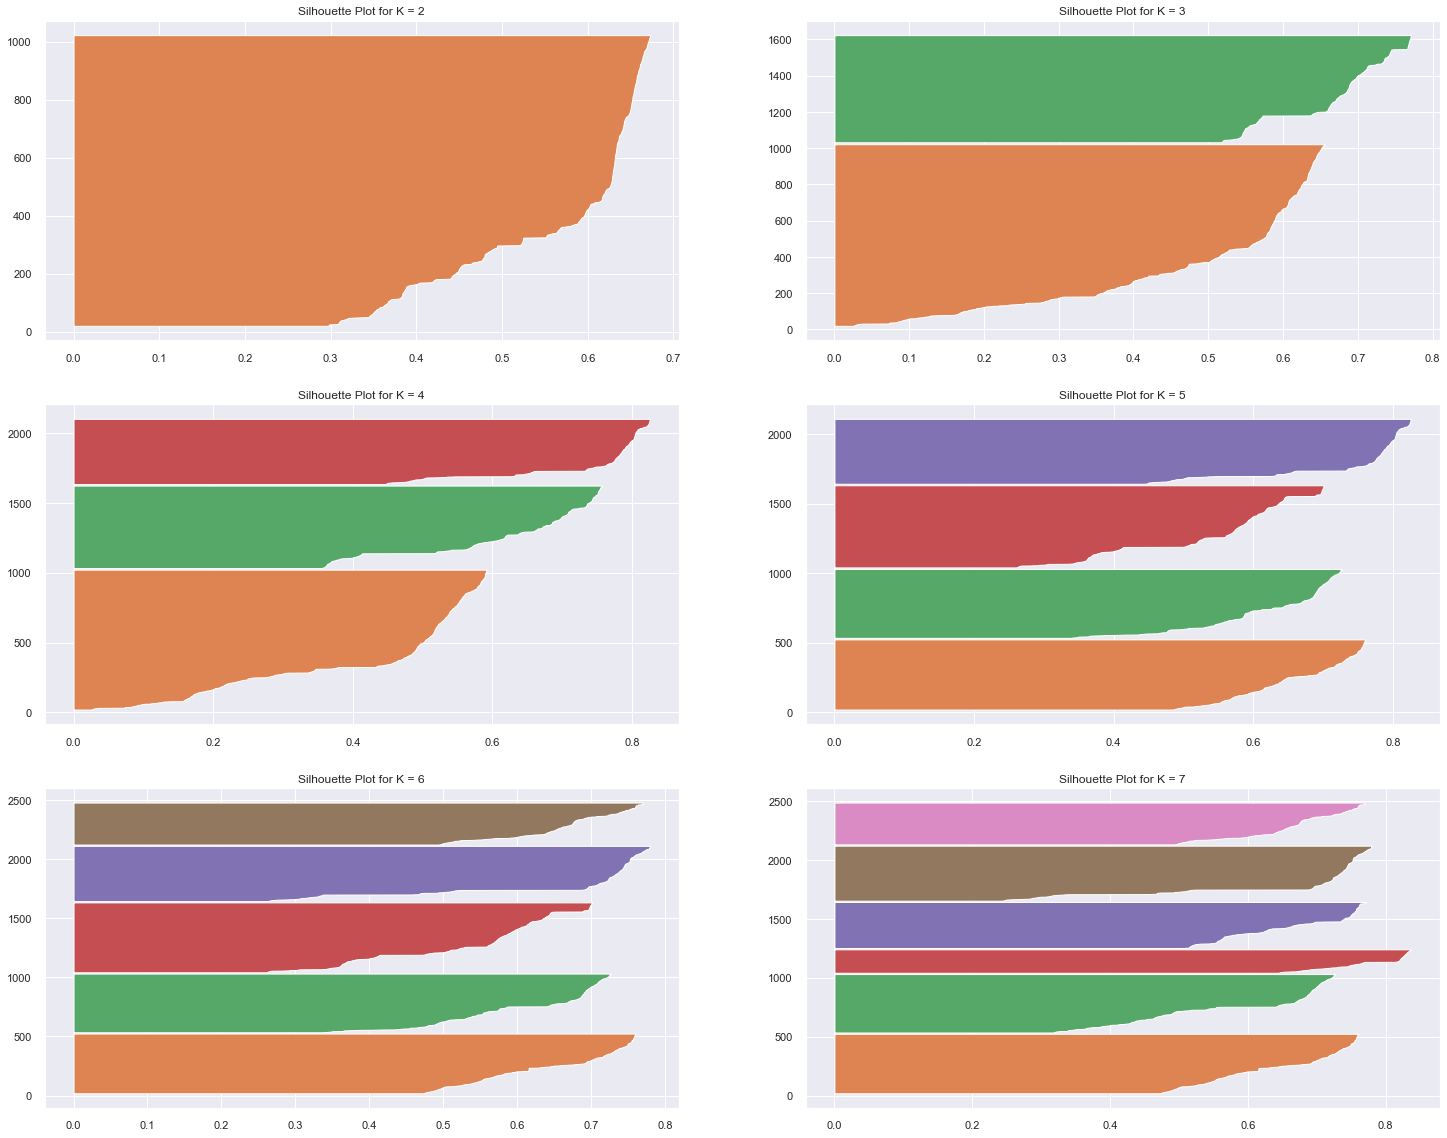

In [78]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(25, 20)

for k in clusters:    
    # model definition and training
    hc_model = hc.linkage(X, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion = 'maxclust')

    # performance
    ss = silhouette_score(X, labels, metric = 'euclidean')
    print(f'K = {k}, Silhouette Score: {ss}')
    
    samples_silhouette_values = silhouette_samples(X, labels)
    
    y_lower = 10
    
    for i in range(k):
        # select cluster
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]

        # cluster size
        size_cluster_i = ith_samples_silhouette_values.shape[0]

        # sort values
        ith_samples_silhouette_values.sort()

        # limits
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i / k)
        
        try:
            ax.ravel()[k - min(clusters)].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
            ax.ravel()[k - min(clusters)].set_title(f'Silhouette Plot for K = {k}')

            y_lower = y_upper + 10
        
        except:
            break

# 8.0. Model Training <a id='model_training'></a>

## 8.1. K-Means <a id='kmeans'></a>

In [79]:
# model definition
k = 8
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation <a id='cluster_validation'></a>

In [80]:
# WSS (Within-cluster sum of squares)
print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
print(f'SS Value: {silhouette_score(X, labels, metric = "euclidean")}')

WSS Value: 23028.619140625
SS Value: 0.6604759097099304


# 9.0. Cluster Analysis <a id='cluster_analysis'></a>

In [81]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,11.988036,17.272100,4
1,18.169922,6.744686,3
2,11.126657,18.117994,4
3,-1.766095,1.709023,2
4,-6.535240,10.058698,7


## 9.1. Visualization Inspection <a id='visualization_inspection'></a>

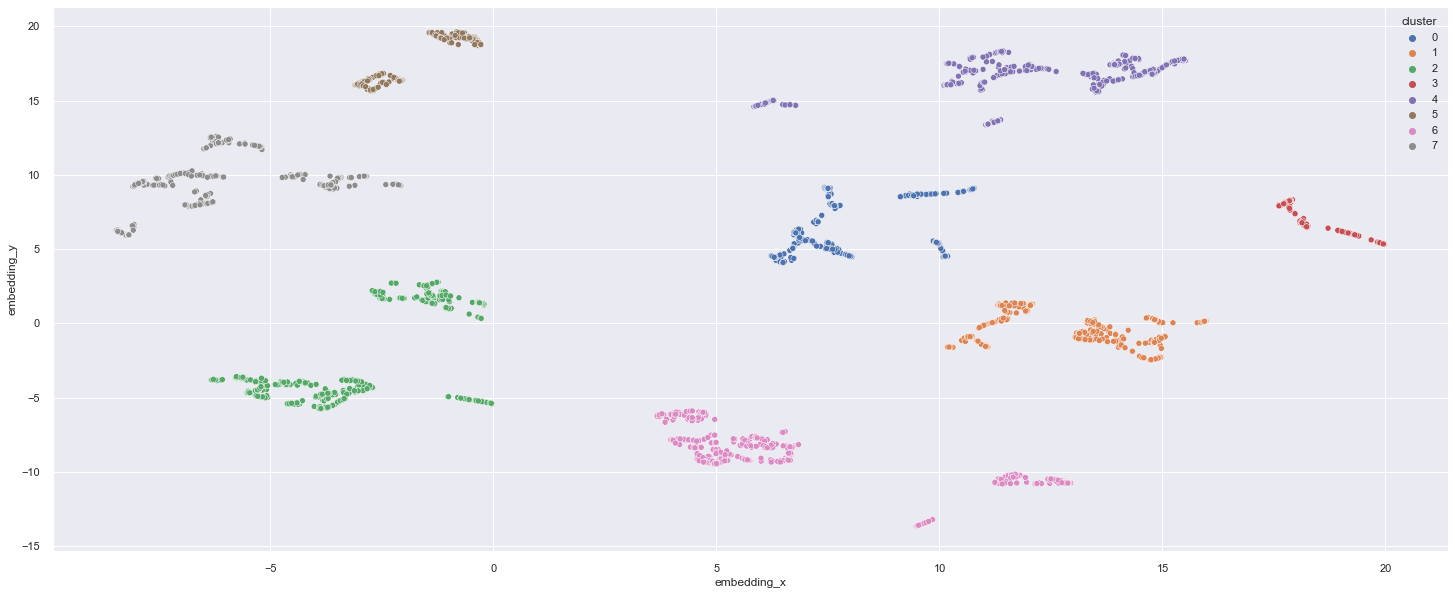

In [82]:
sns.scatterplot(x = 'embedding_x', y = 'embedding_y', data = df9, hue = 'cluster', palette = 'deep');

D:\Anaconda\envs\py385\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



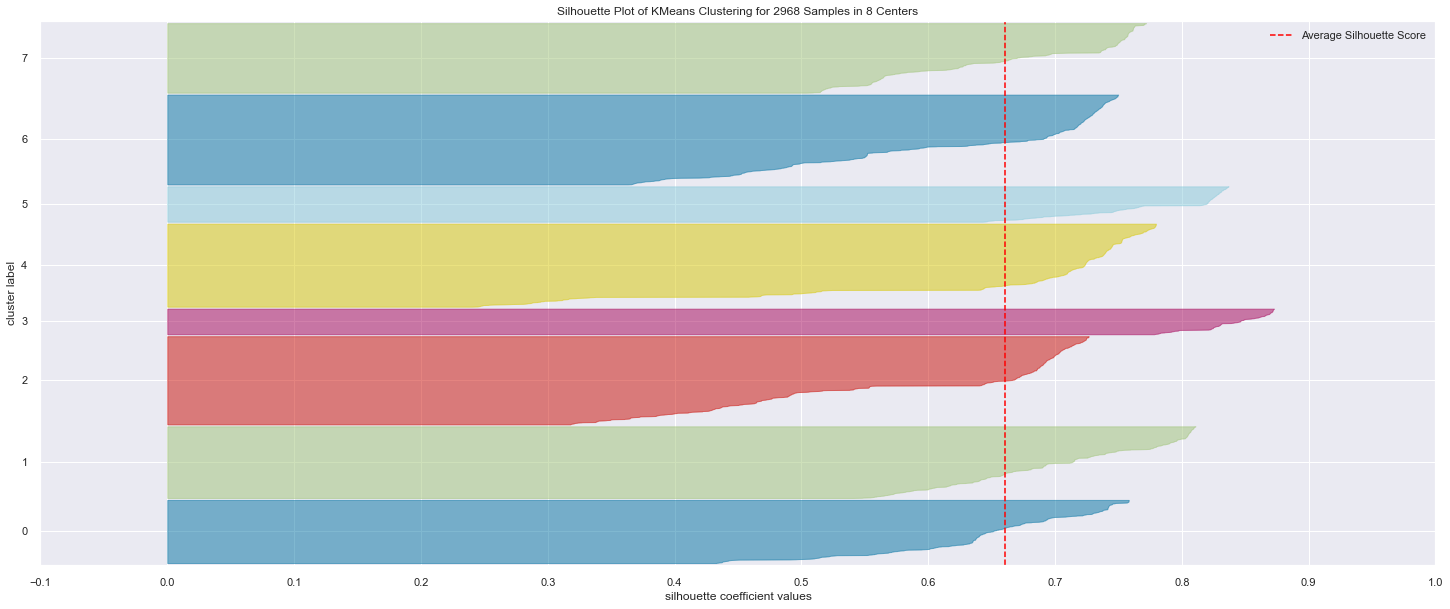

In [83]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2D Plot <a id='2d_plot'></a>

In [84]:
df_viz = df9
# sns.pairplot(df_viz, hue = 'cluster');

## 9.3. UMAP <a id='umap'></a>

UMAP, t-SNE (2009): Manifold - Topology

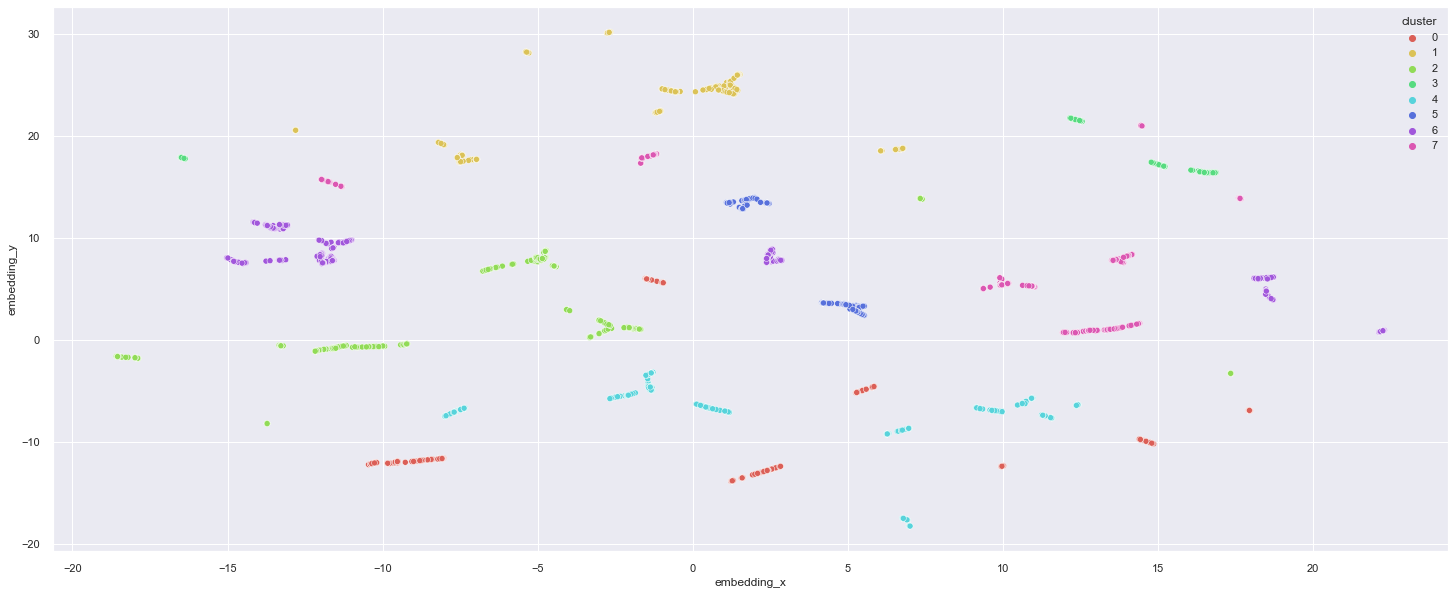

In [85]:
reducer = UMAP(n_neighbors = 80, random_state = 42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x = 'embedding_x', y = 'embedding_y',
               hue = 'cluster',
               palette = sns.color_palette('hls', n_colors = len(df_viz['cluster'].unique())),
               data = df_viz);

## 9.4. Cluster Profile <a id='cluster_profile'></a>

In [86]:
df92 = df4.copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,total_invoices,total_items,total_products,avg_ticket,average_recency_days,frequency,returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294,4
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000,3
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667,4
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000,2
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000,7


In [87]:
# Number of customers
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_gross_revenue, how = 'inner', on = 'cluster')

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_avg_recency_days, how = 'inner', on = 'cluster')

# Avg total_products
df_total_products = df92[['total_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_total_products, how = 'inner', on = 'cluster')

# Avg frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_frequency, how = 'inner', on = 'cluster')

# Avg returns
df_returns = df92[['returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_returns, how = 'inner', on = 'cluster')

df_cluster.sort_values(by = 'gross_revenue', ascending = False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,total_products,frequency,returns
4,4,468,15.768194,8836.136389,21.438034,424.134615,0.094571,149.271368
3,3,145,4.885445,3164.253379,34.427586,173.875862,0.060415,23.482759
0,0,356,11.994609,2404.835787,43.603933,128.373596,0.042313,19.904494
6,6,506,17.048518,2127.020889,58.875494,66.749012,0.048962,16.891304
1,1,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
2,2,497,16.745283,920.480664,81.207243,33.716298,0.105349,12.309859
5,5,200,6.738544,647.933500,47.280000,11.510000,0.025991,0.845000
7,7,392,13.207547,505.728827,149.426020,15.522959,0.426596,9.443878


#### Cluster names

* Cluster 4: Insiders
* Cluster 3: Buy More Products
* Cluster 0: Spend More Money
* Cluster 6: Buy Even More Products
* Cluster 1: Less Days
* Cluster 2: Less 1k
* Cluster 5: Minimun Products
* Cluster 7: Stop Returning

# 10.0. Clusters EDA <a id='clusters_eda'></a>

In [88]:
df10 = df92.copy()

## 10.1. Hypothesis Mindmap <a id='hypothesis_mindmap'></a>

<center><img src="./img/Customers_Clustering.png" width="1000"/></center>

## 10.2. Business Hypothesis <a id='business_hypothesis'></a>

### 10.2.1. Purcharse's Hypotheses

**H1.** Insiders Cluster's customers use credit card as form of Payment for 80% of the purcharses.

**H2.** Insiders Cluster's customers have 10% higher average ticket when compared to Buy More Products Cluster's customers.

**H3.** Insiders Cluster's customers have a basket size higher than 5, on average.

**H4. Insiders Cluster's customers represents at least 10% of all purcharses.**

**H5. Insiders Cluster's customers represents at least 10% of all gross revenue.**

**H6. Insiders Cluster's customers have less average returns than the average returns from other customers.**

**H7. The gross revenue's distribution for Insiders Cluster's customers is concentrated mainly in the 3rd quartile.**

### 10.2.2. Customers's Hypotheses

**H1.** 60% of Insiders Cluster's customers are single.

**H2.** 10% of Insiders Cluster's customers have between 24 and 35 years old.

**H3.** 40% of the delivery locations in Insiders Cluster are within a radius of up to 50 km.

**H4.** 5% of Insiders Cluster's customers receive more than 100,000 dollar per year.

**H5.** 90% of Insiders Cluster's customers have complete education.

### 10.2.3. Product's Hypotheses

**H1.** 30% of all products in big packages are bought by Insiders Cluster's customers.

**H2.** The median of the products' prices bought by the Insiders Cluster's customers is 10% higher than the median of all products' prices.

**H3.** The prices' distribution percentiles from Insiders Cluster's customers.

**H4.** The average products' weight bought by the Insiders Cluster's customers is higher than the average products' weights from the other clusters.

**H5.** The average products' age bought by the Insiders Cluster's customers is lower than 15 days.

## 10.3. Hypothesis Prioritization <a id='hypothesis_prioritization'></a>

**H1.** Insiders Cluster's customers represents at least 10% of all purcharses.

**H2.** Insiders Cluster's customers represents at least 10% of all gross revenue.

**H3.** Insiders Cluster's customers have less average returns than the average returns from other customers.

**H4.** The gross revenue's distribution for Insiders Cluster's customers is concentrated mainly in the 3rd quartile.

## 10.4. Hypotheses Validation <a id='hypotheses_validation'></a>

### H1. Insiders Cluster's customers represents at least 10% of all purcharses.

**True**. Insiders Cluster's customers represents 54.48% of all purcharses.

In [89]:
# total products insiders cluster
total_products_insiders = df10.query("cluster == 4")['total_products'].sum()

# total products all
total_products_all = sum(df10['total_products'])

print(f'Total Products Insiders: {total_products_insiders}')
print(f'Total Products Others: {total_products_all}')
print(f'Insiders representation: {total_products_insiders / total_products_all * 100:.2f}%')

Total Products Insiders: 198495.0
Total Products Others: 364365.0
Insiders representation: 54.48%


### H2. Insiders Cluster's customers represents at least 10% of all gross revenue.

**True**. Insiders Cluster's customers represents 51.73% of all gross revenue.

In [90]:
# total products insiders cluster
gross_revenue_insiders = df10.query("cluster == 4")['gross_revenue'].sum()

# total products all
gross_revenue_all = sum(df10['gross_revenue'])

print(f'Gross Revenue Insiders: {gross_revenue_insiders:.2f}')
print(f'Gross Revenue Others: {gross_revenue_all:.2f}')
print(f'Insiders representation: {gross_revenue_insiders / gross_revenue_all * 100:.2f}%')

Gross Revenue Insiders: 4135311.83
Gross Revenue Others: 7994263.66
Insiders representation: 51.73%


### H3. Insiders Cluster's customers have less average returns than the average returns from other customers.

**False**. Insiders Cluster's customers have MORE average returns than the average returns from other customers.

In [91]:
# mean returns insiders cluster
returns_insiders = df10.query("cluster == 4")['returns'].mean()

# mean returnss all
returns_all = df10.query("cluster != 4")['returns'].mean()

print(f'Average Returns Insiders: {returns_insiders:.2f}')
print(f'Average Returns Others: {returns_all:.2f}')

Average Returns Insiders: 149.27
Average Returns Others: 13.48


### H4. The gross revenue's distribution for Insiders Cluster's customers is concentrated mainly in the 3rd quartile.

**False**. The Insiders Cluster's customers gross revenue is concentrated mainly around the 1st quartile.

In [92]:
p10_gmv = np.percentile(df10.query("cluster == 4")['gross_revenue'], 0.1)
p90_gmv = np.percentile(df10.query("cluster == 4")['gross_revenue'], 0.9)
print(f"P10 Gross Revenue Insiders: {p10_gmv:.2f}")
print(f"P90 Gross Revenue Insiders: {p90_gmv:.2f}")

P10 Gross Revenue Insiders: 617.56
P90 Gross Revenue Insiders: 823.98


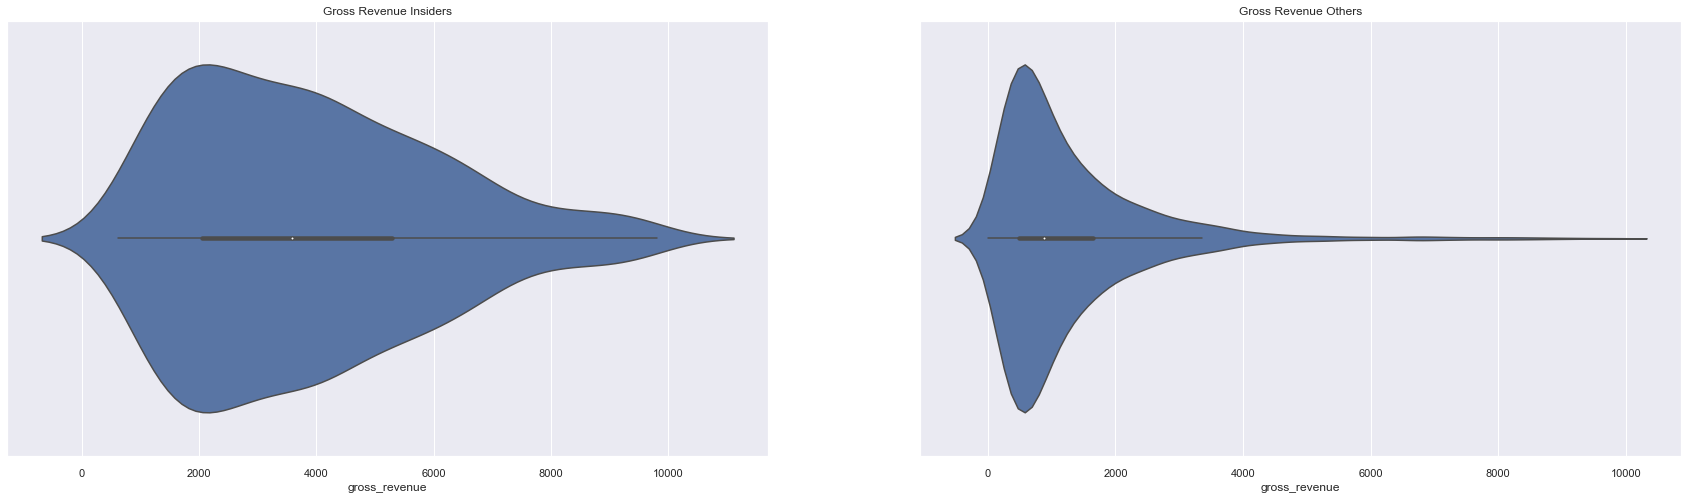

In [93]:
fig, axes = plt.subplots(1, 2, figsize = (30, 8))

sns.violinplot(x = 'gross_revenue', data = df10.query("cluster == 4 & gross_revenue < 10000"), ax = axes.ravel()[0]);
sns.violinplot(x = 'gross_revenue', data = df10.query("cluster != 4 & gross_revenue < 10000"), ax = axes.ravel()[1]);

axes.ravel()[0].set_title('Gross Revenue Insiders');
axes.ravel()[1].set_title('Gross Revenue Others');

## 10.5. Answering Business Questions <a id='answering_business'></a>

 #### 1. Who are the people eligible to join the Insiders program?

In [94]:
df10.query("cluster == 4")['customer_id'].values

array([17850, 12583, 14688, 15311, 16029, 12431, 17511, 13408, 13767,
       13448, 15513, 17920, 13694, 14849, 17377, 12748, 14911, 17841,
       12472, 17346, 12921, 13468, 16928, 17690, 14606, 14092, 15752,
       17017, 12471, 15601, 13418, 18041, 14390, 14060, 15544, 14180,
       14449, 16186, 15061, 15640, 17228, 14031, 12971, 15834, 14156,
       17757, 13798, 14395, 17961, 14573, 18225, 12841, 16905, 16891,
       14680, 13013, 16013, 17949, 12682, 14723, 17954, 17238, 15769,
       13081, 17243, 15708, 13089, 16033, 15351, 18055, 18109, 16241,
       14800, 16839, 16931, 16814, 13269, 12567, 14810, 18118, 17059,
       16327, 17211, 15570, 15808, 17858, 16393, 14527, 15023, 15426,
       15867, 14506, 15555, 12720, 16422, 15502, 17965, 13174, 17677,
       16161, 15039, 14189, 12474, 16719, 15301, 17596, 15078, 14085,
       16919, 17019, 16722, 14667, 16710, 16550, 15984, 17068, 15356,
       17191, 15194, 17218, 15021, 17450, 17091, 12681, 17735, 14733,
       13319, 13488,

#### 2. How many customers will be part of the group?


In [95]:
len(df10.query("cluster == 4"))

468

#### 3. What are the main characteristics of these customers?

In [96]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,total_products,frequency,returns
0,0,356,11.994609,2404.835787,43.603933,128.373596,0.042313,19.904494
1,1,404,13.611860,1689.182401,54.801980,89.202970,0.050037,11.542079
2,2,497,16.745283,920.480664,81.207243,33.716298,0.105349,12.309859
3,3,145,4.885445,3164.253379,34.427586,173.875862,0.060415,23.482759
4,4,468,15.768194,8836.136389,21.438034,424.134615,0.094571,149.271368
5,5,200,6.738544,647.933500,47.280000,11.510000,0.025991,0.845000
6,6,506,17.048518,2127.020889,58.875494,66.749012,0.048962,16.891304
7,7,392,13.207547,505.728827,149.426020,15.522959,0.426596,9.443878


* Number of customers: 468 (15.77% of all customers)
* Mean Gross Revenue: $ 8,836.14
* Mean Recency: 21.4
* Mean Total Products: 424.13
* Mean Frequency: 0.09 purcharses / day
* Mean Returns: 149.27

#### 4. What is the percentage of revenue contribution coming from the Insiders?

In [97]:
df_insiders_gmv = df10.query('cluster == 4')['gross_revenue'].sum()
df_all_gmv = df10['gross_revenue'].sum()

print(f"% Insiders' GMV Contribution: {df_insiders_gmv / df_all_gmv * 100:.2f}%")

% Insiders' GMV Contribution: 51.73%


#### 5. What is the expected revenue of this group for the next months?

Timeseries.

#### 6. What are the conditions for a person to be eligible to join Insiders?

Model.

#### 7. How can a person be removed from the Insiders program?

Model.

#### 8. What is the guarantee that the Insiders program is better than the rest of the base ?

Higher gross revenue.

#### 9. What actions can the marketing team take to increase revenue?

Cross Sell to the Insiders.